In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Potato Disease Classification

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Potato Disease Classification


# Problem Statement

Farmers who grow potatoes are facing lot of economic losses every year because of various diseases that can happen to a potato plant. There are two common diseases known as early blight and late blight early blight is caused by a fungus and late blight is caused by a specific microorganism and if a farmer can detect these diseases early and apply appropriate treatment then it can save lot of waste and prevent the economic loss. 

The treatments for early blight and late blight are little different so it's important that you accurately identify what kind of disease is there in that potato plant.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage", 
                                                              seed=123, 
                                                              shuffle=True, 
                                                              image_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                                              batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

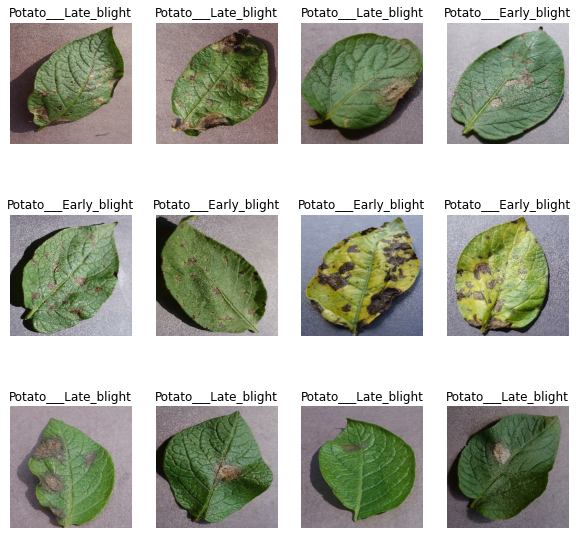

In [ ]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
                                          layers.experimental.preprocessing.Rescaling(1./255)])

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         layers.experimental.preprocessing.RandomRotation(0.2)])

# Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([resize_and_rescale,
                           data_augmentation,
                           layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(n_classes, activation='softmax')])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

# Compiling the Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    validation_data=val_ds,
                    verbose=1,
                    epochs=50)

Epoch 1/50
54/54 [==============================] - 19s 228ms/step - loss: 0.8996 - accuracy: 0.4688 - val_loss: 0.8361 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 7s 134ms/step - loss: 0.6020 - accuracy: 0.7228 - val_loss: 0.5445 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 7s 133ms/step - loss: 0.3990 - accuracy: 0.8287 - val_loss: 0.4290 - val_accuracy: 0.8281
Epoch 4/50
54/54 [==============================] - 7s 134ms/step - loss: 0.3318 - accuracy: 0.8588 - val_loss: 0.1924 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 7s 134ms/step - loss: 0.2796 - accuracy: 0.8895 - val_loss: 0.2253 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 7s 133ms/step - loss: 0.1477 - accuracy: 0.9404 - val_loss: 0.1386 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 7s 135ms/step - loss: 0.1638 - accuracy: 0.9387 - val_loss: 0.1203 - val_accuracy: 0.9583
Epoch

In [ ]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 5s 58ms/step - loss: 0.0128 - accuracy: 0.9961


[0.01276012510061264, 0.99609375]

# Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

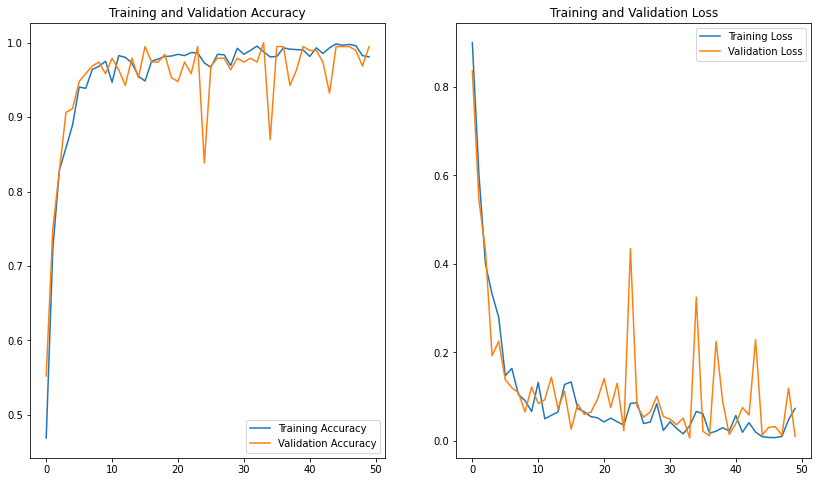

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


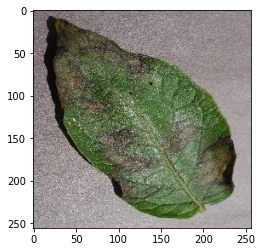

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

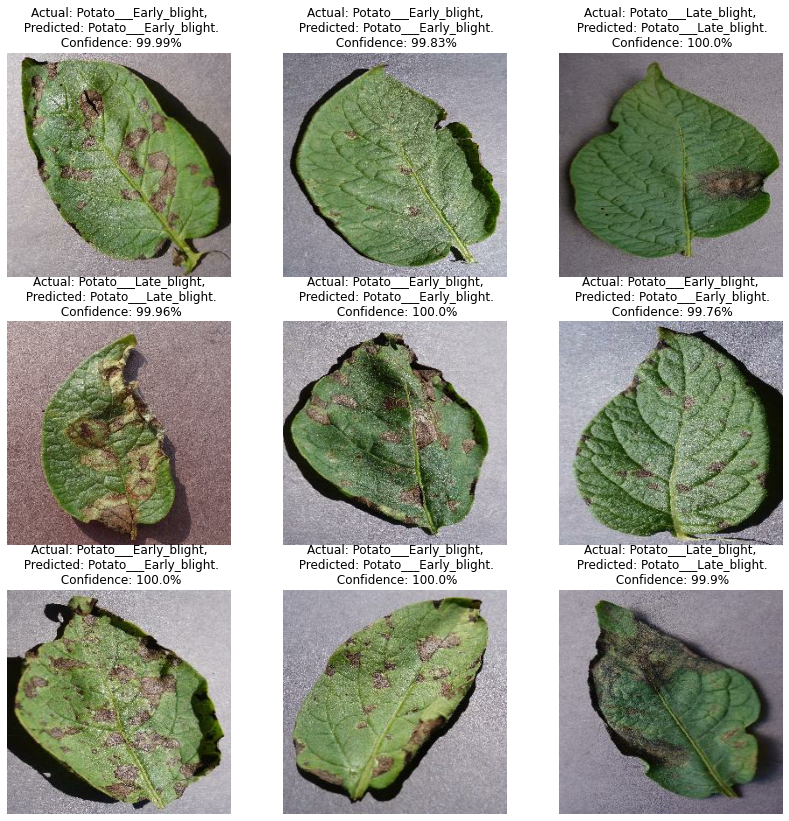

In [ ]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("saved_models") + [0]])+1
model.save(f"saved_models/{model_version}")

INFO:tensorflow:Assets written to: models/1/assets


In [ ]:
model.save("../potatoes.h5")